In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

tensor([[0.4929, 0.4729, 0.5441, 0.5008, 0.5258, 0.5305, 0.4965, 0.4694, 0.4834,
         0.4210, 0.5273, 0.4980, 0.4599, 0.4609, 0.4988, 0.4765, 0.5039, 0.5012,
         0.5042, 0.5084, 0.5218, 0.5243, 0.4950, 0.4815, 0.5162, 0.5396, 0.4823,
         0.5010, 0.5143, 0.4768, 0.5123, 0.4920, 0.4433, 0.5171, 0.4228, 0.4961,
         0.5338, 0.4828, 0.5407, 0.4967, 0.5061, 0.5129, 0.5185, 0.4575, 0.4211,
         0.4768, 0.4764, 0.5089, 0.5266, 0.4691, 0.4772, 0.4561, 0.5675, 0.4870,
         0.5162, 0.5301, 0.5655, 0.4980, 0.4418, 0.5357, 0.4779, 0.4810, 0.4799,
         0.5760, 0.4607, 0.4986, 0.4798, 0.4833, 0.5424, 0.4907, 0.5190, 0.5270,
         0.4964, 0.5523, 0.5643, 0.4699, 0.4723, 0.5154, 0.5321, 0.4992, 0.4821,
         0.5113, 0.4725, 0.4910, 0.5081, 0.4947, 0.5203, 0.4539, 0.5225, 0.5196,
         0.5077, 0.4193, 0.5204, 0.4872, 0.4665, 0.4836, 0.5229, 0.4959, 0.5573,
         0.5006, 0.4675, 0.4897, 0.4859, 0.4950, 0.5093, 0.4325, 0.5148, 0.4674,
         0.4757, 0.4808, 0.4

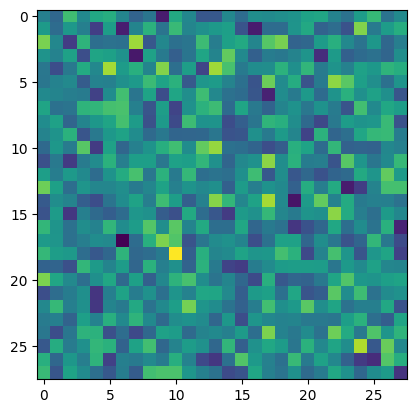

In [3]:
# input Image -> Hidden dim -> Mean, StD -> Parameterization Trick -> Decoder -> Output Image
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()
        
    def encode(self, x):
        #q_phi(z/x)
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

        
    def decode(self, z):
        # p_t(x/z)
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self,x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_reparameterized = mu + sigma*epsilon
        x_reconstrcuted = self.decode(z_reparameterized)
        return x_reconstrcuted, mu, sigma


if __name__ == "__main__":
    x = torch.randn(1, 784)
    vae = VariationalAutoEncoder(input_dim=784)
    out = vae(x)
    
    print(out[0].detach())
    out_img = torch.reshape(out[0],(28,28))
    out_img = out_img.detach().numpy()
    plt.imshow(out_img)

In [4]:
import torch
import torchvision.datasets as datasets
from torch import nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [5]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR_RATE = 3e-4 # Karpathy Constant


# Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download = True)

train_loader = DataLoader(dataset=dataset, batch_size = BATCH_SIZE, shuffle=True)
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [10]:
# Start taining
for epoch in range(NUM_EPOCHS):
    print(epoch)
    for (x, _) in train_loader:
        x = x.to(device).view(x.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(x)

        # compute loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1+torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        loss = reconstruction_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0
1
2
3
4
5
6
7
8
9


In [17]:
def run_inference(digit, num_examples):
    model.to("cpu")
    images = []
    idx = 0
    for x, y in dataset:
        if y==idx:
            images.append(x)
            idx+=1
        if idx==10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1,784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated {digit} {example}.png")

for idx in range(10):
    run_inference(idx, num_examples=1)